### Imports Globais


In [1]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
)

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, calinski_harabasz_score
)


### Regressão

In [ ]:

df = pd.read_csv("framingham.csv")

# verifica nulos
print("\n🔹 Valores ausentes por coluna:")
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
display(missing)



🔹 Valores ausentes por coluna:


,0
glucose,388
education,105
BPMeds,53
totChol,50
cigsPerDay,29
BMI,19
heartRate,1


In [ ]:

TARGET = "glucose"

# remove linhas com alvo nulo
df_reg = df.dropna(subset=[TARGET]).copy()

# não usar o rótulo de classificação como feature na regressão
cols_to_drop = [TARGET, "TenYearCHD"] if "TenYearCHD" in df_reg.columns else [TARGET]

X = df_reg.drop(columns=cols_to_drop)
y = df_reg[TARGET]

print("X:", X.shape, " | y:", y.shape)


X: (3852, 14)  | y: (3852,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print("Treino:", X_train.shape, " | Teste:", X_test.shape)


Treino: (3081, 14)  | Teste: (771, 14)


SVR - MSE: 386.6883942970512
SVR - MAE: 11.050496591233882
SVR - R2: 0.1159226338471302


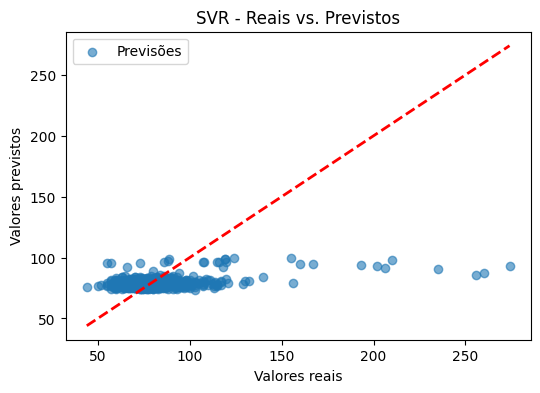

In [ ]:
# SVR
svr_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf'))
])

svr_pipe.fit(X_train, y_train)
y_pred_svr = svr_pipe.predict(X_test)

mse_svr = mean_squared_error(y_test, y_pred_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr  = r2_score(y_test, y_pred_svr)

print('SVR - MSE:', mse_svr)
print('SVR - MAE:', mae_svr)
print('SVR - R2:', r2_svr)

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_svr, alpha=0.6, label='Previsões')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores reais')
plt.ylabel('Valores previstos')
plt.title('SVR - Reais vs. Previstos')
plt.legend()
plt.show()

Random Forest - MSE: 484.53832908560315
Random Forest - MAE: 12.453378728923477
Random Forest - R2: -0.107789569316741


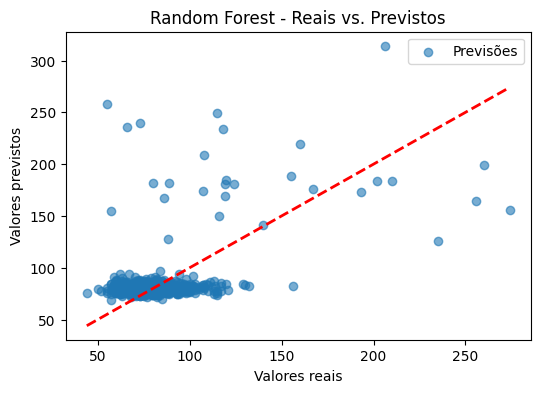

In [ ]:
# Random Forest
rf_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])

rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf  = r2_score(y_test, y_pred_rf)

print('Random Forest - MSE:', mse_rf)
print('Random Forest - MAE:', mae_rf)
print('Random Forest - R2:', r2_rf)

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_rf, alpha=0.6, label='Previsões')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores reais')
plt.ylabel('Valores previstos')
plt.title('Random Forest - Reais vs. Previstos')
plt.legend()
plt.show()


### Classificação

In [ ]:
TARGET = "TenYearCHD"

df_clf = df.dropna(subset=[TARGET]).copy()

X = df_clf.drop(columns=[TARGET])
y = df_clf[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Treino:", X_train.shape, " | Teste:", X_test.shape)
print("Proporção de risco (1):", y.mean().round(3))

Treino: (3392, 15)  | Teste: (848, 15)
Proporção de risco (1): 0.152



🔹 Random Forest Classifier
Accuracy : 0.847877358490566
Precision: 0.5
Recall   : 0.03875968992248062
F1-score : 0.07194244604316546
ROC-AUC  : 0.6382303155761124


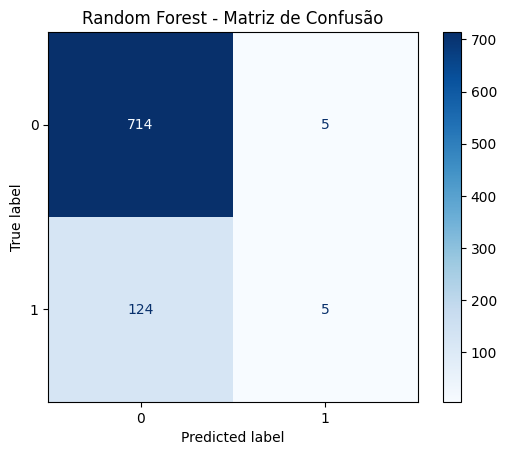

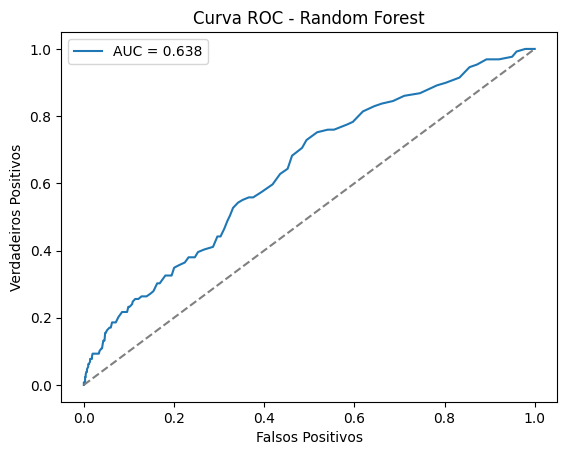

In [ ]:
rf_clf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
y_prob_rf = rf_clf.predict_proba(X_test)[:, 1]

# metricas
print("\n🔹 Random Forest Classifier")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall   :", recall_score(y_test, y_pred_rf))
print("F1-score :", f1_score(y_test, y_pred_rf))
print("ROC-AUC  :", roc_auc_score(y_test, y_prob_rf))

# matriz de confusao
ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test, cmap="Blues")
plt.title("Random Forest - Matriz de Confusão")
plt.show()

# ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob_rf):.3f}")
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("Falsos Positivos")
plt.ylabel("Verdadeiros Positivos")
plt.title("Curva ROC - Random Forest")
plt.legend()
plt.show()


🔹 SVC (RBF)
Accuracy : 0.8502358490566038
Precision: 0.75
Recall   : 0.023255813953488372
F1-score : 0.045112781954887216
ROC-AUC  : 0.5526301603217216


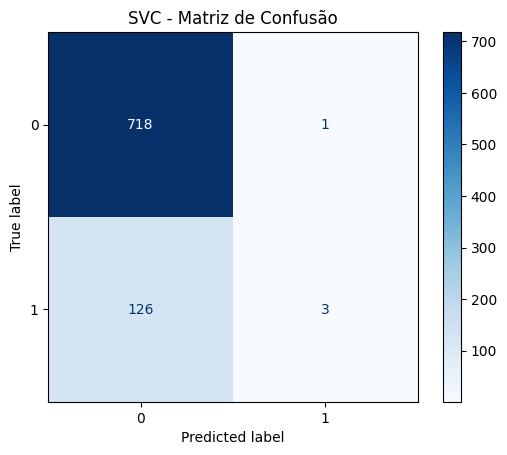

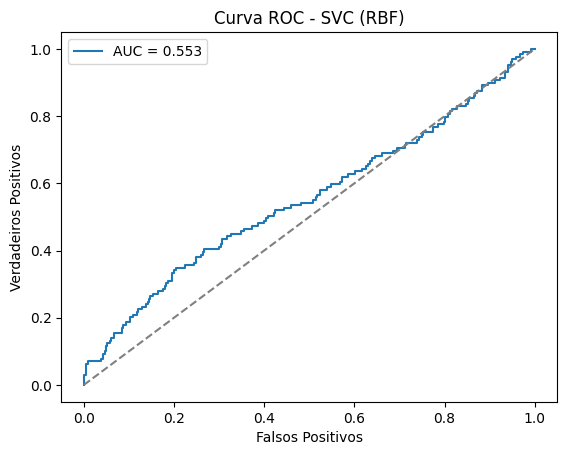

In [ ]:
svc_clf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", probability=True, random_state=42))
])

svc_clf.fit(X_train, y_train)
y_pred_svc = svc_clf.predict(X_test)
y_prob_svc = svc_clf.predict_proba(X_test)[:, 1]

# metricas
print("\n🔹 SVC (RBF)")
print("Accuracy :", accuracy_score(y_test, y_pred_svc))
print("Precision:", precision_score(y_test, y_pred_svc))
print("Recall   :", recall_score(y_test, y_pred_svc))
print("F1-score :", f1_score(y_test, y_pred_svc))
print("ROC-AUC  :", roc_auc_score(y_test, y_prob_svc))

# matriz de confusão
ConfusionMatrixDisplay.from_estimator(svc_clf, X_test, y_test, cmap="Blues")
plt.title("SVC - Matriz de Confusão")
plt.show()

# ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_svc)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob_svc):.3f}")
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("Falsos Positivos")
plt.ylabel("Verdadeiros Positivos")
plt.title("Curva ROC - SVC (RBF)")
plt.legend()
plt.show()

### Clusterização

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

features = [
    "age", "male", "currentSmoker", "cigsPerDay", "BPMeds",
    "prevalentStroke", "prevalentHyp", "diabetes",
    "totChol", "sysBP", "diaBP", "BMI", "heartRate", "glucose"
]

df_cluster = df[features].dropna().copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

print("Shape após limpeza:", X_scaled.shape)

Shape após limpeza: (3751, 14)


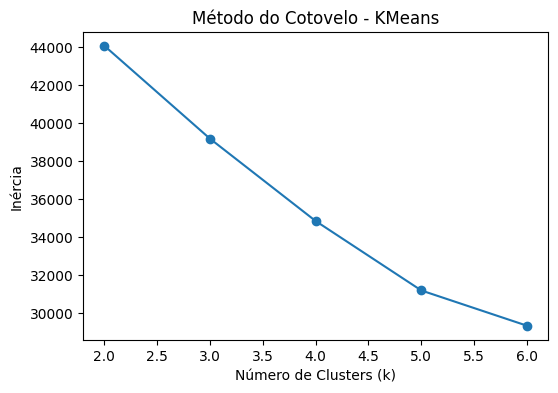

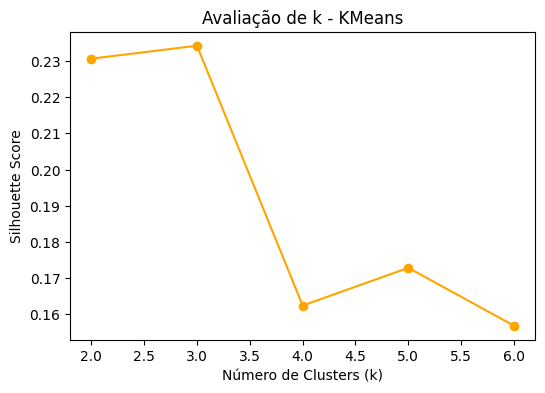

Melhor k escolhido: 4
Silhouette: 0.16242149242199963
Davies-Bouldin: 1.6323660936974433
Calinski-Harabasz: 633.6502478528276


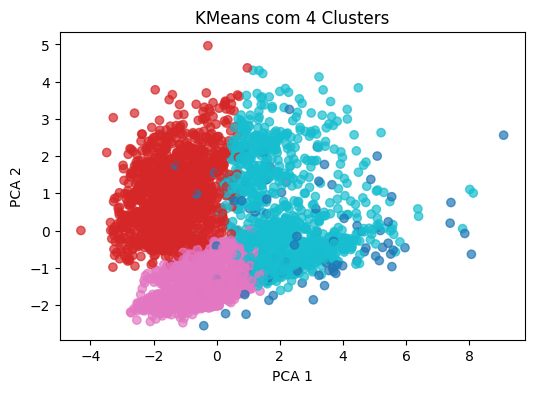

In [ ]:
inertias = []
silhouettes = []

K_range = range(2, 7)  # testar de 2 até 6 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

# curva de inércia
plt.figure(figsize=(6, 4))
plt.plot(K_range, inertias, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo - KMeans')
plt.show()

# curva Silhouette
plt.figure(figsize=(6, 4))
plt.plot(K_range, silhouettes, marker='o', color='orange')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Avaliação de k - KMeans')
plt.show()

# escolhe k com melhor equilíbrio
best_k = 4
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_km = kmeans.fit_predict(X_scaled)

print(f"Melhor k escolhido: {best_k}")
print("Silhouette:", silhouette_score(X_scaled, labels_km))
print("Davies-Bouldin:", davies_bouldin_score(X_scaled, labels_km))
print("Calinski-Harabasz:", calinski_harabasz_score(X_scaled, labels_km))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_km, cmap='tab10', alpha=0.7)
plt.title(f'KMeans com {best_k} Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

Número de clusters encontrados: 8
Silhouette: 0.06767283093349698
Davies-Bouldin: 2.49318661599839


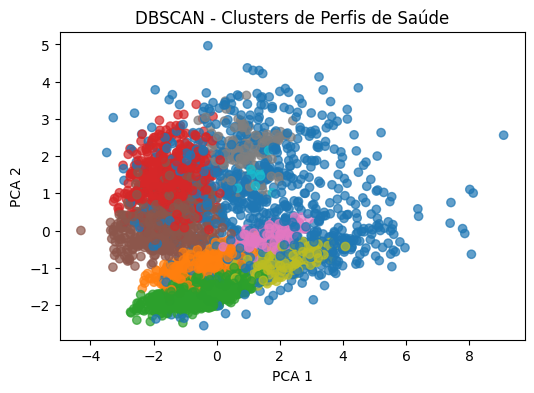

In [ ]:
dbscan = DBSCAN(eps=1.5, min_samples=10)
labels_db = dbscan.fit_predict(X_scaled)

n_clusters_db = len(set(labels_db)) - (1 if -1 in labels_db else 0)
print(f"Número de clusters encontrados: {n_clusters_db}")

if n_clusters_db > 1:
    print("Silhouette:", silhouette_score(X_scaled, labels_db))
    print("Davies-Bouldin:", davies_bouldin_score(X_scaled, labels_db))
else:
    print("DBSCAN encontrou poucos clusters válidos — ajuste eps/min_samples.")

# PCA
plt.figure(figsize=(6, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_db, cmap='tab10', alpha=0.7)
plt.title('DBSCAN - Clusters de Perfis de Saúde')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

### Metricas

In [ ]:
# Random Forest
rf_report = classification_report(y_test, y_pred_rf, output_dict=True, zero_division=0)
rf_df = pd.DataFrame(rf_report).transpose()
print("Random Forest Report:")
display(rf_df.round(3))

# SVC
svc_report = classification_report(y_test, y_pred_svc, output_dict=True, zero_division=0)
svc_df = pd.DataFrame(svc_report).transpose()
print("SVC Report:")
display(svc_df.round(3))


Random Forest Report:


,precision,recall,f1-score,support
0,0.852,0.993,0.917,719.000
1,0.500,0.039,0.072,129.000
accuracy,0.848,0.848,0.848,0.848
macro avg,0.676,0.516,0.495,848.000
weighted avg,0.798,0.848,0.789,848.000


SVC Report:


,precision,recall,f1-score,support
0,0.851,0.999,0.919,719.00
1,0.750,0.023,0.045,129.00
accuracy,0.850,0.850,0.850,0.85
macro avg,0.800,0.511,0.482,848.00
weighted avg,0.835,0.850,0.786,848.00


# Clusters e risco:
Sim, os clusters mostram níveis diferentes de risco.
Um grupo tem pessoas jovens e saudáveis (baixo risco), outro tem meia-idade com pressão e colesterol altos (médio), e outro reúne idosos, hipertensos e diabéticos (alto risco).

# Regressão e classificação:
Sim, eles apontam padrões parecidos — idade, pressão, glicemia e tabagismo aparecem como fatores que mais influenciam tanto a glicemia (regressão) quanto o risco cardíaco (classificação).

# Variáveis mais importantes:
As que mais impactam a saúde são idade, pressão sistólica, colesterol, glicemia, diabetes e tabagismo.
Essas variáveis aumentam o risco de doenças cardíacas.